# 1. Create a custom gym environment

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import math
from enum import Enum
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

In [6]:
class GameEnv(Env):
    def __init__(self, size = 10, mode='static'):
        self.mode = mode
        self.size = size
        self.GAME_LENGTH = 2 * size**2
        self.action_space = Discrete(4)
        self.observation_space = Box(low=0, high=3, shape=(self.size, self.size), dtype=np.int32)
        self.state, self.player, self.goals = self.createBoard()
        self.goals_remaining = len(self.goals)
        #self.visited = np.zeros((self.size,self.size), dtype=np.int32)
        self.time_remaining = self.GAME_LENGTH
        
    def step(self, action):
        self.time_remaining -= 1
        done = False
        
        #evaluate move, save value of the new space before move then update the state
        invalid_move = False
        improved = False
        if Action(action) == Action.UP:
            new_pos = (self.player[0] -1, self.player[1])
            if new_pos[0] >= 0 and self.state[new_pos] != 1:
                #improved = self.distanceToGoalImproved(new_pos)
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.DOWN:
            new_pos = (self.player[0] +1, self.player[1])
            if new_pos[0] < self.size and self.state[new_pos] != 1:
                #improved = self.distanceToGoalImproved(new_pos)
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.LEFT:
            new_pos = (self.player[0], self.player[1] -1)
            if new_pos[1] >= 0 and self.state[new_pos] != 1:
                #improved = self.distanceToGoalImproved(new_pos)
                new_space_val= self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.RIGHT:
            new_pos = (self.player[0], self.player[1] +1)
            if new_pos[1] < self.size and self.state[new_pos] != 1:
                #improved = self.distanceToGoalImproved(new_pos)
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        else:
            print("Invalid input to step function")
            
        #evaluate reward 
        reward = 0
        if invalid_move:
            reward = -0.5
            done = False
        else:
            if new_space_val == 0:
                #if(improved):
                #    reward = 0.04
                #else:
                reward = -0.04
                done = False
            elif new_space_val == 3:
                self.goals_remaining -= 1
                if self.goals_remaining == 0:
                    reward = 20
                    done = True
                else:
                    reward = 20
                    done = False
        
        #evaluate if out of time
        if self.time_remaining == 0:
            done = True
            reward = -20
            
        #placeholder for required return value
        info = {}
        
        return self.state, reward, done, info
    
    def distanceToGoalImproved(self, new_pos):
        distances_before = []
        distances_after = []
        for goal in self.goals:
            distances_before.append(math.sqrt((self.player[0] - goal[0])**2 + (self.player[1] - goal[1])**2))
            distances_after.append(math.sqrt((new_pos[0] - goal[0])**2 + (new_pos[1] - goal[1])**2))
        index_of_closest = distances_before.index(min(distances_before))
        distance_change = distances_after[index_of_closest] - distances_before[index_of_closest]
        if distance_change < 0:
            return True
        return False
    
    def evalMove(self, new_pos):
        # check if we back_tracked
        #if self.visited[new_pos] == -1:
        #    back_track = True
        #else:
        #    back_track = False
        #update the matrix of visited cells
        #self.visited[self.player] = -1
        #process the move
        new_space_val = self.state[new_pos]
        self.state[self.player] = 0
        self.state[new_pos] = 2
        self.player = new_pos
        return new_space_val
        
    def render(self, mode='human'):
        clear_output(wait=True)
        plt.figure(figsize=(5,5))
        plt.title(f'Clock: {self.time_remaining}, Goals: {self.goals_remaining}')
        plt.imshow(self.state)
        plt.show()
    
    def reset(self):
        self.state, self.player, self.goals =  self.createBoard()
        self.goals_remaining = len(self.goals)
        self.time_remaining = self.GAME_LENGTH
        return self.state
    
    def createBoard(self):
        board = np.matrix([[1,1,1,1,1,1,1,1,1,1],
                           [1,0,0,0,0,0,0,0,0,1],
                           [1,1,1,0,1,1,1,0,1,1],
                           [1,0,0,0,0,1,0,0,0,1],
                           [1,0,1,1,1,1,0,1,0,1],
                           [1,0,1,1,3,1,0,1,0,1],
                           [1,0,0,0,0,0,0,1,0,1],
                           [1,1,1,0,1,0,1,1,0,1],
                           [1,3,0,0,1,0,0,0,3,1],
                           [1,1,1,1,1,1,1,1,1,1]])
        if self.mode == 'static':
            player_pos = (1,1) #(np.random.randint(self.size), np.random.randint(self.size))
            goals = [(5,5),(8,1),(8,8)]
        elif self.mode == 'random':
            player_pos = (np.random.randint(self.size), np.random.randint(self.size))
            goal_pos = (np.random.randint(self.size), np.random.randint(self.size))
            player_goal_distance = math.sqrt((player_pos[0] - goal_pos[0])**2 + (player_pos[1] - goal_pos[1])**2)
            while player_goal_distance < self.size/2:
                goal_pos = (np.random.randint(self.size), np.random.randint(self.size))
                player_goal_distance = math.sqrt((player_pos[0] - goal_pos[0])**2 + (player_pos[1] - goal_pos[1])**2)
        
        board[player_pos] = 2
        for coord in goals:
            if board[coord] == 0:
                board[coord] = 3
        return board, player_pos, goals

### Test

In [7]:
env = GameEnv()
episodes = 15
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    num_moves = 0
    num_backtrack = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        #if reward == -0.25:
        #    num_backtrack += 1
        if reward == 20:
            print("found one")
        score += reward
        num_moves += 1
        
    print(f'Episode:{episode} Score:{score} Moves:{num_moves} Backtracks:{num_backtrack}')

found one
Episode:1 Score:-52.99999999999992 Moves:200 Backtracks:0
Episode:2 Score:-68.89999999999992 Moves:200 Backtracks:0
Episode:3 Score:-75.79999999999994 Moves:200 Backtracks:0
Episode:4 Score:-77.17999999999994 Moves:200 Backtracks:0
Episode:5 Score:-74.87999999999994 Moves:200 Backtracks:0
Episode:6 Score:-70.27999999999992 Moves:200 Backtracks:0
Episode:7 Score:-73.95999999999992 Moves:200 Backtracks:0
Episode:8 Score:-78.55999999999993 Moves:200 Backtracks:0
Episode:9 Score:-78.09999999999994 Moves:200 Backtracks:0
Episode:10 Score:-74.87999999999994 Moves:200 Backtracks:0
Episode:11 Score:-76.71999999999993 Moves:200 Backtracks:0
Episode:12 Score:-80.85999999999994 Moves:200 Backtracks:0
Episode:13 Score:-72.57999999999991 Moves:200 Backtracks:0
found one
Episode:14 Score:-54.37999999999992 Moves:200 Backtracks:0
found one
Episode:15 Score:-49.31999999999992 Moves:200 Backtracks:0


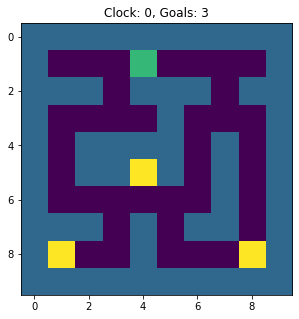

Episode:15 Score:-74.41999999999993


In [8]:
state = env.reset()
done = False
score = 0
while not done:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    score += reward
    env.render()

print(f'Episode:{episode} Score:{score}')

# 2. Create Deep Learning Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states[0],states[1])))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [25]:
del model
del env

In [26]:
env = GameEnv()
states = env.observation_space.shape
actions = env.action_space.n
model = build_model(states,actions)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 20,604
Trainable params: 20,604
Non-trainable params: 0
_________________________________________________________________


# 3. Build Agent

In [13]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, MaxBoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
#from tf_agents.environments import tf_py_environment

In [17]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=100000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                   nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2)
    return dqn

In [27]:
#env =  tf_py_environment.TFPyEnvironment(env)

dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 73s 7ms/step - reward: -0.2807
50 episodes - episode_reward: -56.138 [-76.720, -27.440] - loss: 2.583 - mae: 9.722 - mean_q: 13.432

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 76s 8ms/step - reward: -0.2319
50 episodes - episode_reward: -46.432 [-71.200, 21.520] - loss: 2.625 - mae: 10.343 - mean_q: 13.881

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 69s 7ms/step - reward: 0.1553
83 episodes - episode_reward: 18.753 [-64.240, 56.960] - loss: 3.459 - mae: 14.258 - mean_q: 19.113

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 57s 6ms/step - reward: 0.1926
85 episodes - episode_reward: 22.481 [-56.680, 55.660] - loss: 6.213 - mae: 28.635 - mean_q: 38.916

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: 0.3363
95 epi

In [28]:
def dqn_tester(dqn, num_eps, vis = False):
    scores = dqn.test(env, nb_episodes=num_eps, visualize=vis)
    print("Mean Reward: " + str(np.mean(scores.history['episode_reward'])))
    #num_win = 0
    #for steps in scores.history['episode_steps']:
    #    if steps < 100:
    #        num_win += 1
    #print(f'Win Rate: {round(num_win/num_eps, 2) * 100}%')

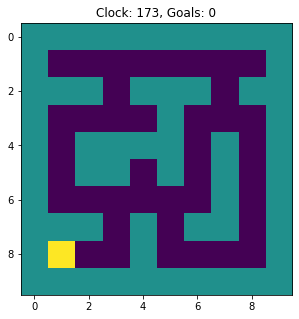

Episode 1: reward: 59.040, steps: 27
Mean Reward: 59.04000000000001


In [31]:
dqn_tester(dqn, 1, True)

# 4. Saving and Reloading Model

In [102]:
dqn.save_weights('saved_models/10x10_maze_easy.h5f', overwrite=False)

In [103]:
del model
del dqn
del env

In [104]:
env = GameEnv()
actions = env.action_space.n
states = env.observation_space.shape
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [105]:
dqn.load_weights('saved_models/10x10_maze_easy.h5f')

In [106]:
dqn_tester(dqn, 15)

Testing for 15 episodes ...
Episode 1: reward: 58.920, steps: 30
Episode 2: reward: 58.920, steps: 30
Episode 3: reward: 58.920, steps: 30
Episode 4: reward: 58.920, steps: 30
Episode 5: reward: 58.920, steps: 30
Episode 6: reward: 58.920, steps: 30
Episode 7: reward: 58.920, steps: 30
Episode 8: reward: 58.920, steps: 30
Episode 9: reward: 58.920, steps: 30
Episode 10: reward: 58.920, steps: 30
Episode 11: reward: 58.920, steps: 30
Episode 12: reward: 58.920, steps: 30
Episode 13: reward: 58.920, steps: 30
Episode 14: reward: 58.920, steps: 30
Episode 15: reward: 58.920, steps: 30
Mean Reward: 58.920000000000044


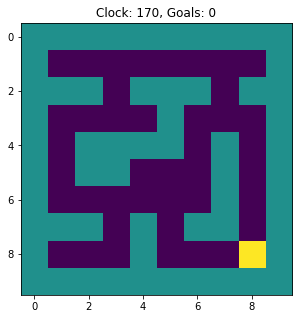

Episode 1: reward: 58.920, steps: 30
Mean Reward: 58.920000000000016


In [109]:
dqn_tester(dqn, 1, True)